# U.S. Manufacturing Employment Analysis
## Impact of "Liberation Day" Tariffs (April 2, 2025)

This notebook analyzes manufacturing employment trends using Bureau of Labor Statistics data.

## 1. Setup & Configuration

In [1]:
import os
import json
from pathlib import Path
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Configuration
BLS_API_KEY = os.getenv('BLS_API_KEY')  # Optional - works without key at lower rate limits
BLS_API_URL = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# BLS Series IDs
SERIES_ID = 'CES3000000001'  # Manufacturing employment, seasonally adjusted, thousands

# Time range
START_YEAR = 2015
END_YEAR = 2026

# Key dates
LIBERATION_DAY = pd.Timestamp('2025-04-02')

# Output settings
FIGURE_SIZE = (1080, 1350)  # pixels, 4:5 ratio
DPI = 150
FIGURE_DIR = Path('figures')
CACHE_DIR = Path('.cache')

# Create directories
FIGURE_DIR.mkdir(exist_ok=True)
CACHE_DIR.mkdir(exist_ok=True)

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

print(f"API Key configured: {BLS_API_KEY is not None}")
print(f"Date range: {START_YEAR} - {END_YEAR}")

API Key configured: False
Date range: 2015 - 2026


## 2. Data Acquisition

In [2]:
def fetch_bls_data(series_ids, start_year, end_year, api_key=None):
    """
    Fetch data from BLS API.
    
    The BLS API limits requests to 20 years per call and 10 years without registration.
    This function handles pagination for longer time ranges.
    """
    if isinstance(series_ids, str):
        series_ids = [series_ids]
    
    all_data = []
    
    # BLS API allows max 20 years per request (10 without key)
    max_years = 20 if api_key else 10
    
    # Split into chunks if needed
    current_start = start_year
    while current_start <= end_year:
        current_end = min(current_start + max_years - 1, end_year)
        
        payload = {
            'seriesid': series_ids,
            'startyear': str(current_start),
            'endyear': str(current_end),
        }
        
        if api_key:
            payload['registrationkey'] = api_key
        
        response = requests.post(BLS_API_URL, json=payload)
        response.raise_for_status()
        
        result = response.json()
        
        if result['status'] != 'REQUEST_SUCCEEDED':
            raise ValueError(f"BLS API error: {result.get('message', 'Unknown error')}")
        
        for series in result['Results']['series']:
            all_data.extend(series['data'])
        
        current_start = current_end + 1
    
    return all_data


def parse_bls_data(raw_data):
    """Convert raw BLS API response to DataFrame."""
    records = []
    for item in raw_data:
        year = int(item['year'])
        # Period format: 'M01' through 'M12' for monthly data
        month = int(item['period'][1:])
        
        # Skip annual averages (M13)
        if month > 12:
            continue
            
        records.append({
            'date': pd.Timestamp(year=year, month=month, day=1),
            'value': float(item['value']),
            'year': year,
            'month': month,
        })
    
    df = pd.DataFrame(records)
    df = df.sort_values('date').reset_index(drop=True)
    return df

In [3]:
# Check cache first
cache_file = CACHE_DIR / f'bls_{SERIES_ID}_{START_YEAR}_{END_YEAR}.json'

if cache_file.exists():
    print(f"Loading cached data from {cache_file}")
    with open(cache_file, 'r') as f:
        raw_data = json.load(f)
else:
    print(f"Fetching data from BLS API...")
    raw_data = fetch_bls_data(SERIES_ID, START_YEAR, END_YEAR, BLS_API_KEY)
    
    # Cache the response
    with open(cache_file, 'w') as f:
        json.dump(raw_data, f)
    print(f"Cached data to {cache_file}")

print(f"Retrieved {len(raw_data)} data points")

Loading cached data from .cache\bls_CES3000000001_2015_2026.json
Retrieved 132 data points


## 3. Data Cleaning & Transformation

In [4]:
# Parse raw data
df = parse_bls_data(raw_data)

# Add derived columns
df['value_thousands'] = df['value']  # Original is in thousands
df['value_millions'] = df['value'] / 1000

# Month-over-month change
df['mom_change'] = df['value'].diff()
df['mom_pct_change'] = df['value'].pct_change() * 100

# Year-over-year change (12-month lag)
df['yoy_change'] = df['value'].diff(12)
df['yoy_pct_change'] = (df['value'] / df['value'].shift(12) - 1) * 100

# Index to January 2025 = 100
jan_2025_value = df.loc[df['date'] == '2025-01-01', 'value'].values
if len(jan_2025_value) > 0:
    df['indexed_jan2025'] = (df['value'] / jan_2025_value[0]) * 100
else:
    df['indexed_jan2025'] = None

# Flag for pre/post Liberation Day
df['post_liberation'] = df['date'] >= LIBERATION_DAY

print(f"Data range: {df['date'].min()} to {df['date'].max()}")
print(f"Total observations: {len(df)}")
df.head(10)

Data range: 2015-01-01 00:00:00 to 2025-12-01 00:00:00
Total observations: 132


,date,value,year,month,value_thousands,value_millions,mom_change,mom_pct_change,yoy_change,yoy_pct_change,indexed_jan2025,post_liberation
0,2015-01-01,12265.0,2015,1,12265.0,12.265,NaN,NaN,NaN,NaN,96.158369,False
1,2015-02-01,12275.0,2015,2,12275.0,12.275,10.0,0.081533,NaN,NaN,96.236770,False
2,2015-03-01,12286.0,2015,3,12286.0,12.286,11.0,0.089613,NaN,NaN,96.323011,False
3,2015-04-01,12291.0,2015,4,12291.0,12.291,5.0,0.040697,NaN,NaN,96.362211,False
4,2015-05-01,12306.0,2015,5,12306.0,12.306,15.0,0.122041,NaN,NaN,96.479812,False
5,2015-06-01,12307.0,2015,6,12307.0,12.307,1.0,0.008126,NaN,NaN,96.487652,False
6,2015-07-01,12323.0,2015,7,12323.0,12.323,16.0,0.130007,NaN,NaN,96.613093,False
7,2015-08-01,12318.0,2015,8,12318.0,12.318,-5.0,-0.040575,NaN,NaN,96.573893,False
8,2015-09-01,12326.0,2015,9,12326.0,12.326,8.0,0.064946,NaN,NaN,96.636613,False
9,2015-10-01,12334.0,2015,10,12334.0,12.334,8.0,0.064903,NaN,NaN,96.699334,False


## 4. Exploratory Analysis

In [5]:
# Summary statistics
print("=" * 50)
print("SUMMARY STATISTICS")
print("=" * 50)
print(f"\nManufacturing Employment (thousands):")
print(df['value'].describe())

print(f"\n\nMonth-over-Month % Change:")
print(df['mom_pct_change'].describe())

print(f"\n\nYear-over-Year % Change:")
print(df['yoy_pct_change'].describe())

SUMMARY STATISTICS

Manufacturing Employment (thousands):
count      132.000000
mean     12554.257576
std        285.590365
min      11382.000000
25%      12325.750000
50%      12676.000000
75%      12785.500000
max      12900.000000
Name: value, dtype: float64


Month-over-Month % Change:
count    131.000000
mean       0.031104
std        0.971718
min      -10.264901
25%       -0.040556
50%        0.070104
75%        0.195828
max        2.928510
Name: mom_pct_change, dtype: float64


Year-over-Year % Change:
count    120.000000
mean       0.376819
std        2.716853
min      -10.973797
25%       -0.383206
50%        0.364843
75%        2.045893
max        7.107714
Name: yoy_pct_change, dtype: float64


In [6]:
# Check for missing values or data quality issues
print("Missing values:")
print(df.isnull().sum())

print("\nData continuity check (should have no gaps):")
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='MS')
missing_dates = set(date_range) - set(df['date'])
if missing_dates:
    print(f"Missing dates: {sorted(missing_dates)}")
else:
    print("No missing dates - data is continuous")

Missing values:
date                0
value               0
year                0
month               0
value_thousands     0
value_millions      0
mom_change          1
mom_pct_change      1
yoy_change         12
yoy_pct_change     12
indexed_jan2025     0
post_liberation     0
dtype: int64

Data continuity check (should have no gaps):
No missing dates - data is continuous


In [7]:
# Recent data around Liberation Day
print("\nData around Liberation Day (April 2, 2025):")
mask = (df['date'] >= '2024-10-01') & (df['date'] <= '2025-12-01')
df.loc[mask, ['date', 'value', 'mom_change', 'mom_pct_change', 'yoy_pct_change']]


Data around Liberation Day (April 2, 2025):


,date,value,mom_change,mom_pct_change,yoy_pct_change
117,2024-10-01,12750.0,-50.0,-0.390625,-0.669991
118,2024-11-01,12770.0,20.0,0.156863,-0.684399
119,2024-12-01,12760.0,-10.0,-0.078309,-0.816168
120,2025-01-01,12755.0,-5.0,-0.039185,-0.862739
121,2025-02-01,12763.0,8.0,0.062721,-0.700226
122,2025-03-01,12764.0,1.0,0.007835,-0.576414
123,2025-04-01,12764.0,0.0,0.000000,-0.646065
124,2025-05-01,12753.0,-11.0,-0.086180,-0.747140
125,2025-06-01,12736.0,-17.0,-0.133302,-0.802243
126,2025-07-01,12727.0,-9.0,-0.070666,-0.880062


## 5. Visualization Iteration

Trying multiple approaches to find the clearest narrative.

In [8]:
def add_liberation_day_line(ax, y_min, y_max):
    """Add vertical line and label for Liberation Day."""
    ax.axvline(x=LIBERATION_DAY, color='#d62728', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.annotate(
        'Liberation Day\nApril 2, 2025',
        xy=(LIBERATION_DAY, y_max),
        xytext=(10, -10),
        textcoords='offset points',
        fontsize=9,
        color='#d62728',
        ha='left',
        va='top'
    )

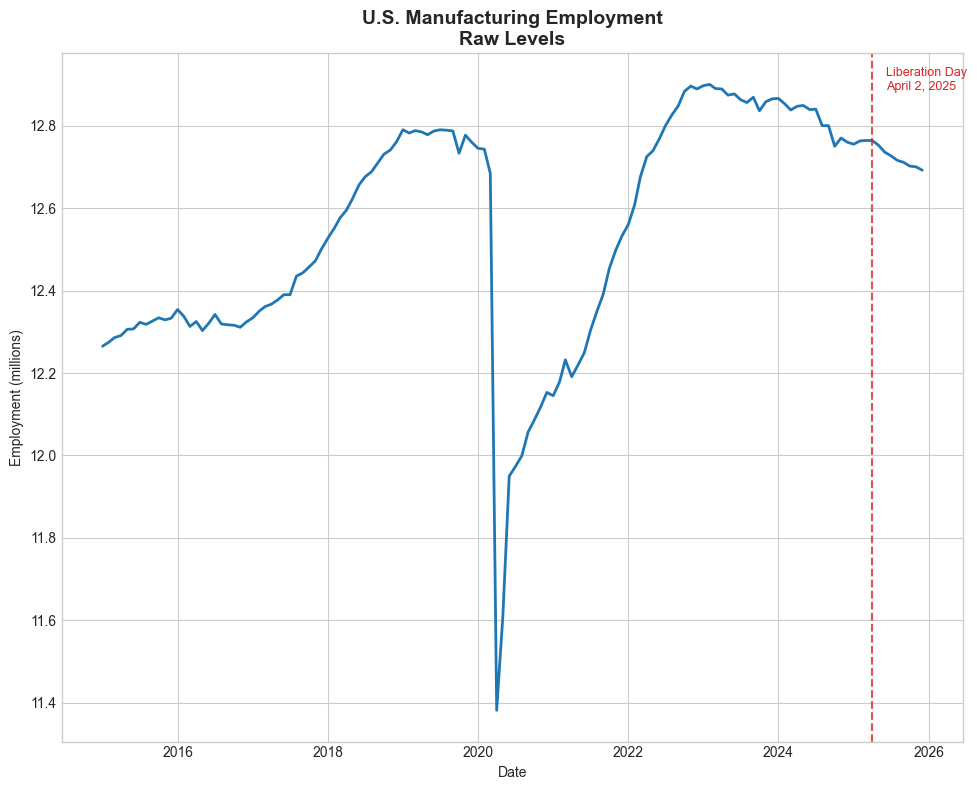

In [9]:
# View 1: Raw employment levels
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['date'], df['value_millions'], linewidth=2, color='#1f77b4')

y_min, y_max = ax.get_ylim()
add_liberation_day_line(ax, y_min, y_max)

ax.set_xlabel('Date')
ax.set_ylabel('Employment (millions)')
ax.set_title('U.S. Manufacturing Employment\nRaw Levels', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

plt.tight_layout()
plt.show()

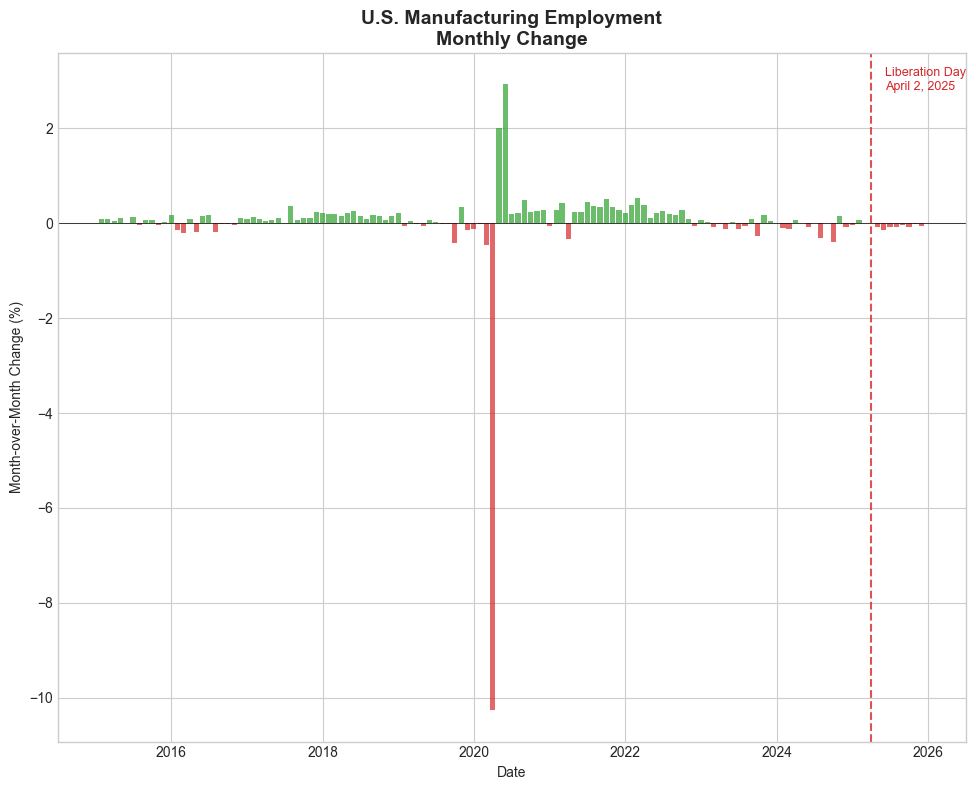

In [10]:
# View 2: Month-over-month % change
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#d62728' if x < 0 else '#2ca02c' for x in df['mom_pct_change']]
ax.bar(df['date'], df['mom_pct_change'], width=25, color=colors, alpha=0.7)

y_min, y_max = ax.get_ylim()
add_liberation_day_line(ax, y_min, y_max)

ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Month-over-Month Change (%)')
ax.set_title('U.S. Manufacturing Employment\nMonthly Change', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

plt.tight_layout()
plt.show()

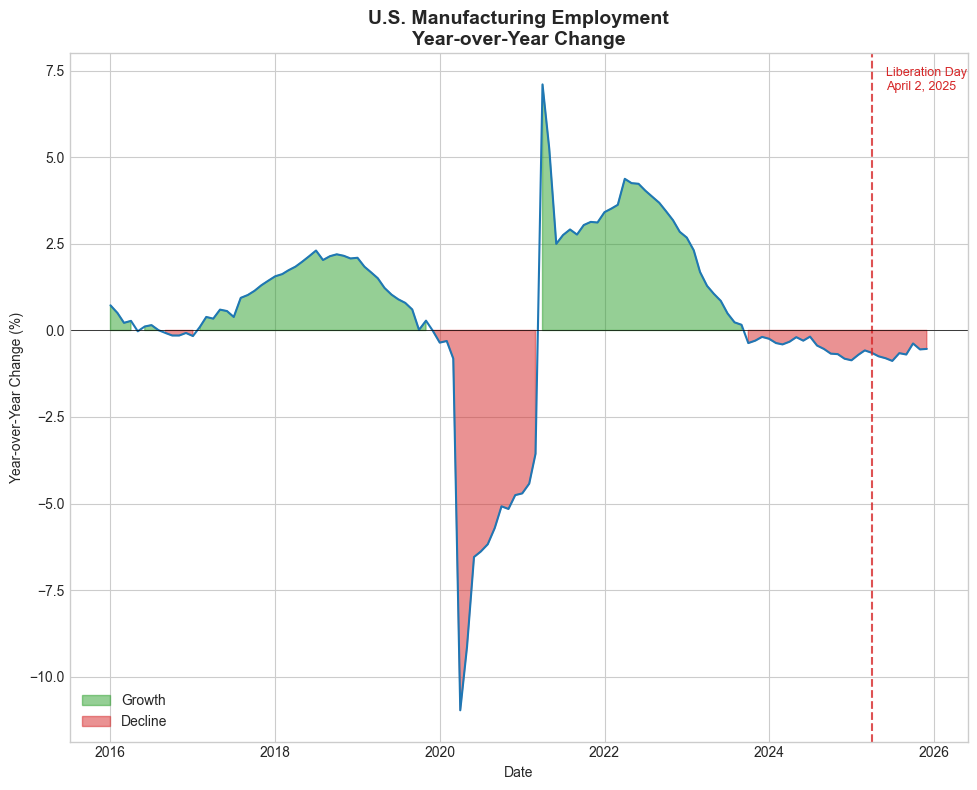

In [11]:
# View 3: Year-over-year % change
fig, ax = plt.subplots(figsize=(10, 8))

df_yoy = df.dropna(subset=['yoy_pct_change'])
ax.fill_between(
    df_yoy['date'], 
    df_yoy['yoy_pct_change'], 
    0,
    where=df_yoy['yoy_pct_change'] >= 0,
    color='#2ca02c',
    alpha=0.5,
    label='Growth'
)
ax.fill_between(
    df_yoy['date'], 
    df_yoy['yoy_pct_change'], 
    0,
    where=df_yoy['yoy_pct_change'] < 0,
    color='#d62728',
    alpha=0.5,
    label='Decline'
)
ax.plot(df_yoy['date'], df_yoy['yoy_pct_change'], linewidth=1.5, color='#1f77b4')

y_min, y_max = ax.get_ylim()
add_liberation_day_line(ax, y_min, y_max)

ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Year-over-Year Change (%)')
ax.set_title('U.S. Manufacturing Employment\nYear-over-Year Change', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

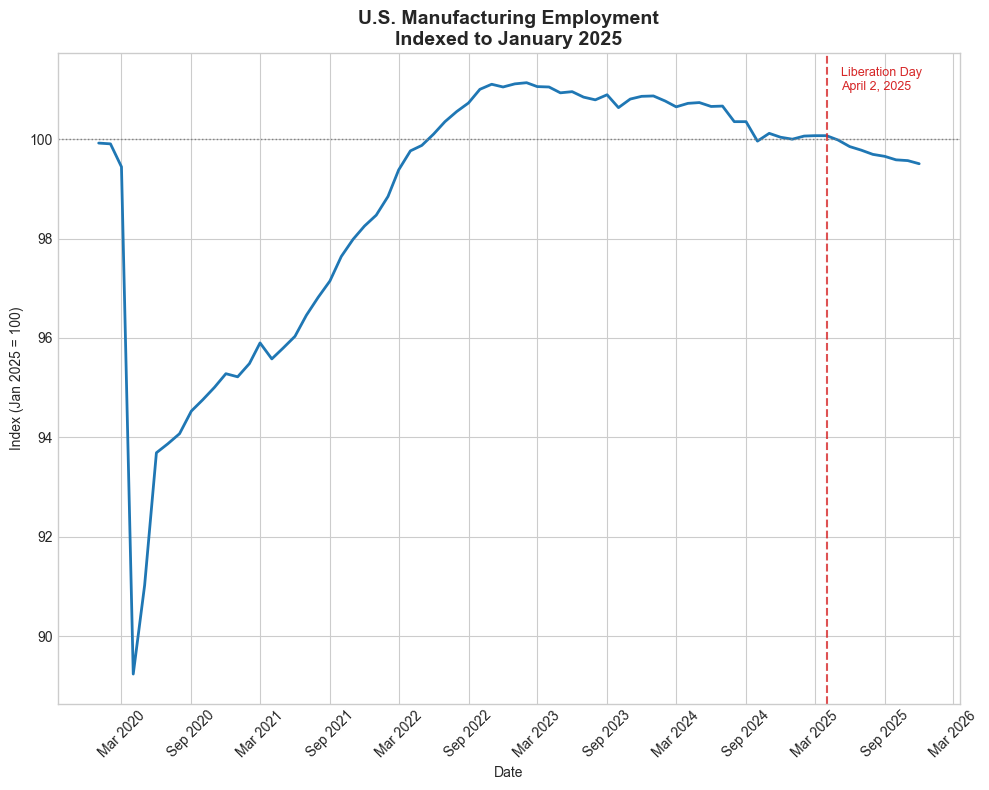

In [12]:
# View 4: Indexed to Jan 2025 = 100
fig, ax = plt.subplots(figsize=(10, 8))

df_recent = df[df['date'] >= '2020-01-01'].copy()
ax.plot(df_recent['date'], df_recent['indexed_jan2025'], linewidth=2, color='#1f77b4')

ax.axhline(y=100, color='gray', linestyle=':', linewidth=1, label='Jan 2025 baseline')

y_min, y_max = ax.get_ylim()
add_liberation_day_line(ax, y_min, y_max)

ax.set_xlabel('Date')
ax.set_ylabel('Index (Jan 2025 = 100)')
ax.set_title('U.S. Manufacturing Employment\nIndexed to January 2025', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

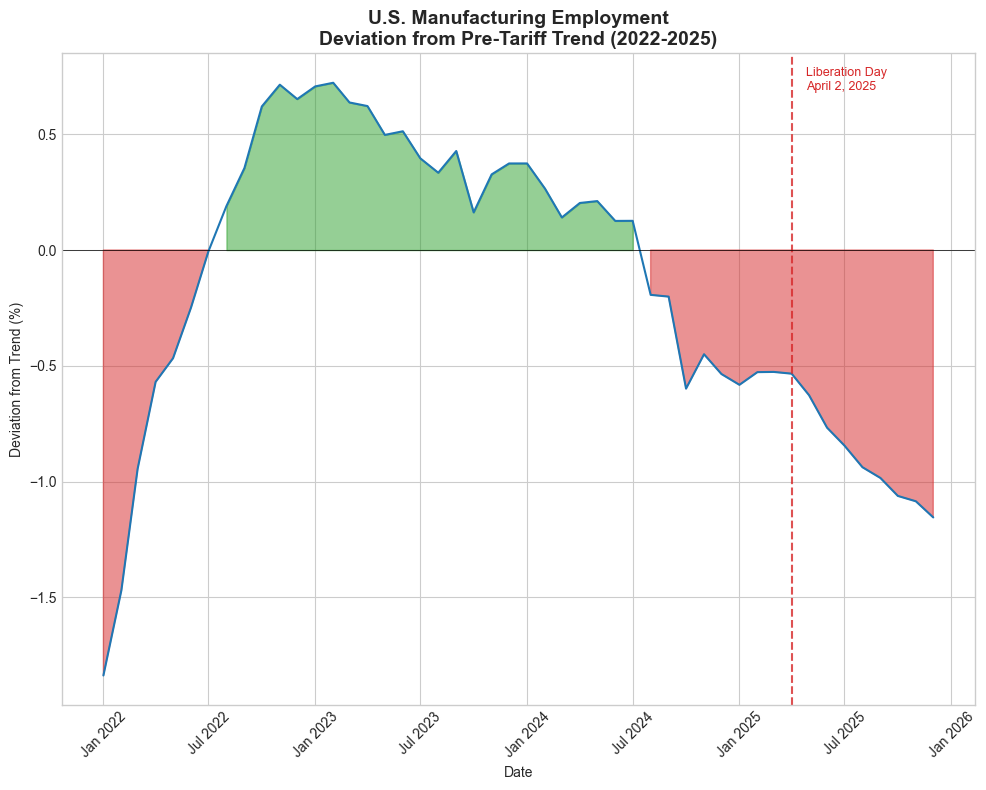

Pre-tariff trend: 0.9 thousand jobs per month


In [13]:
# View 5: Deviation from pre-tariff trend
import numpy as np

# Fit trend line to pre-Liberation Day data (2022-2025)
df_pre = df[(df['date'] >= '2022-01-01') & (df['date'] < LIBERATION_DAY)].copy()
df_pre['date_numeric'] = (df_pre['date'] - df_pre['date'].min()).dt.days

# Linear regression
coeffs = np.polyfit(df_pre['date_numeric'], df_pre['value'], 1)
trend_fn = np.poly1d(coeffs)

# Apply trend to all data from 2022
df_trend = df[df['date'] >= '2022-01-01'].copy()
df_trend['date_numeric'] = (df_trend['date'] - df_pre['date'].min()).dt.days
df_trend['trend'] = trend_fn(df_trend['date_numeric'])
df_trend['deviation'] = df_trend['value'] - df_trend['trend']
df_trend['deviation_pct'] = (df_trend['deviation'] / df_trend['trend']) * 100

fig, ax = plt.subplots(figsize=(10, 8))

ax.fill_between(
    df_trend['date'], 
    df_trend['deviation_pct'], 
    0,
    where=df_trend['deviation_pct'] >= 0,
    color='#2ca02c',
    alpha=0.5
)
ax.fill_between(
    df_trend['date'], 
    df_trend['deviation_pct'], 
    0,
    where=df_trend['deviation_pct'] < 0,
    color='#d62728',
    alpha=0.5
)
ax.plot(df_trend['date'], df_trend['deviation_pct'], linewidth=1.5, color='#1f77b4')

y_min, y_max = ax.get_ylim()
add_liberation_day_line(ax, y_min, y_max)

ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Deviation from Trend (%)')
ax.set_title('U.S. Manufacturing Employment\nDeviation from Pre-Tariff Trend (2022-2025)', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Pre-tariff trend: {coeffs[0]*30:.1f} thousand jobs per month")

## 6. Final Visualization

Publication-ready chart at 1080x1350px (4:5 ratio).

In [14]:
def create_final_visualization(df, output_path):
    """
    Create publication-ready visualization.
    
    Shows employment levels starting from Oct 2024 (one month before election).
    """
    # Figure dimensions: 1080x1215 at 150 DPI (10% shorter height)
    fig_width = FIGURE_SIZE[0] / DPI
    fig_height = (FIGURE_SIZE[1] * 0.9) / DPI
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=DPI)
    
    # Filter to Oct 2024 onwards
    df_plot = df[df['date'] >= '2024-10-01'].copy()
    
    # Main line plot (in millions)
    ax.plot(
        df_plot['date'], 
        df_plot['value_millions'], 
        linewidth=2.5, 
        color='#1f77b4',
        marker='o',
        markersize=6,
        zorder=3
    )
    
    # Liberation Day marker (crimson)
    CRIMSON = '#A41034'
    ax.axvline(
        x=LIBERATION_DAY, 
        color=CRIMSON, 
        linestyle='--', 
        linewidth=2, 
        alpha=0.9,
        zorder=4
    )
    
    # Set y-axis limits with padding for annotation
    y_min = df_plot['value_millions'].min()
    y_max = df_plot['value_millions'].max()
    y_range = y_max - y_min
    ax.set_ylim(y_min - y_range * 0.05, y_max + y_range * 0.35)
    
    # Liberation Day annotation - positioned above the line, no box
    ax.annotate(
        '"Liberation Day"\nTariffs Announced\nApril 2, 2025',
        xy=(LIBERATION_DAY, y_max + y_range * 0.08),
        fontsize=11,
        color=CRIMSON,
        ha='center',
        va='bottom',
        fontweight='bold'
    )
    
    # Styling
    ax.set_xlabel('')
    ax.set_ylabel('Employment (millions)', fontsize=12, fontweight='bold')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='both', labelsize=10)
    
    # Grid (gray)
    ax.grid(True, alpha=0.3, zorder=0, color='gray')
    ax.set_axisbelow(True)
    
    # Spines - black for x and y axis
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Get latest and peak values for subtitle
    latest = df_plot.iloc[-1]
    peak = df_plot.loc[df_plot['value_millions'].idxmax()]
    change_from_peak = (latest['value_millions'] - peak['value_millions']) * 1000  # back to thousands for display
    
    # Title and subtitle - reduced padding
    ax.set_title(
        f'U.S. Manufacturing Employment\n'
        f'Seasonally adjusted · Latest: {latest["value_millions"]:.3f}M ({latest["date"].strftime("%b %Y")}) · '
        f'{change_from_peak:+,.0f}K from peak',
        fontsize=14,
        fontweight='bold',
        color='#333333',
        pad=8
    )
    
    # Source citation
    fig.text(
        0.5, 0.02,
        f'Source: Bureau of Labor Statistics, Current Employment Statistics (CES3000000001)\n'
        f'Data retrieved: {datetime.now().strftime("%B %d, %Y")}',
        ha='center',
        fontsize=9,
        color='#888888'
    )
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    
    # Save
    fig.savefig(
        output_path,
        dpi=DPI,
        bbox_inches='tight',
        facecolor='white',
        edgecolor='none'
    )
    
    print(f"Saved to {output_path}")
    return fig, ax

Saved to figures\manufacturing_employment.png


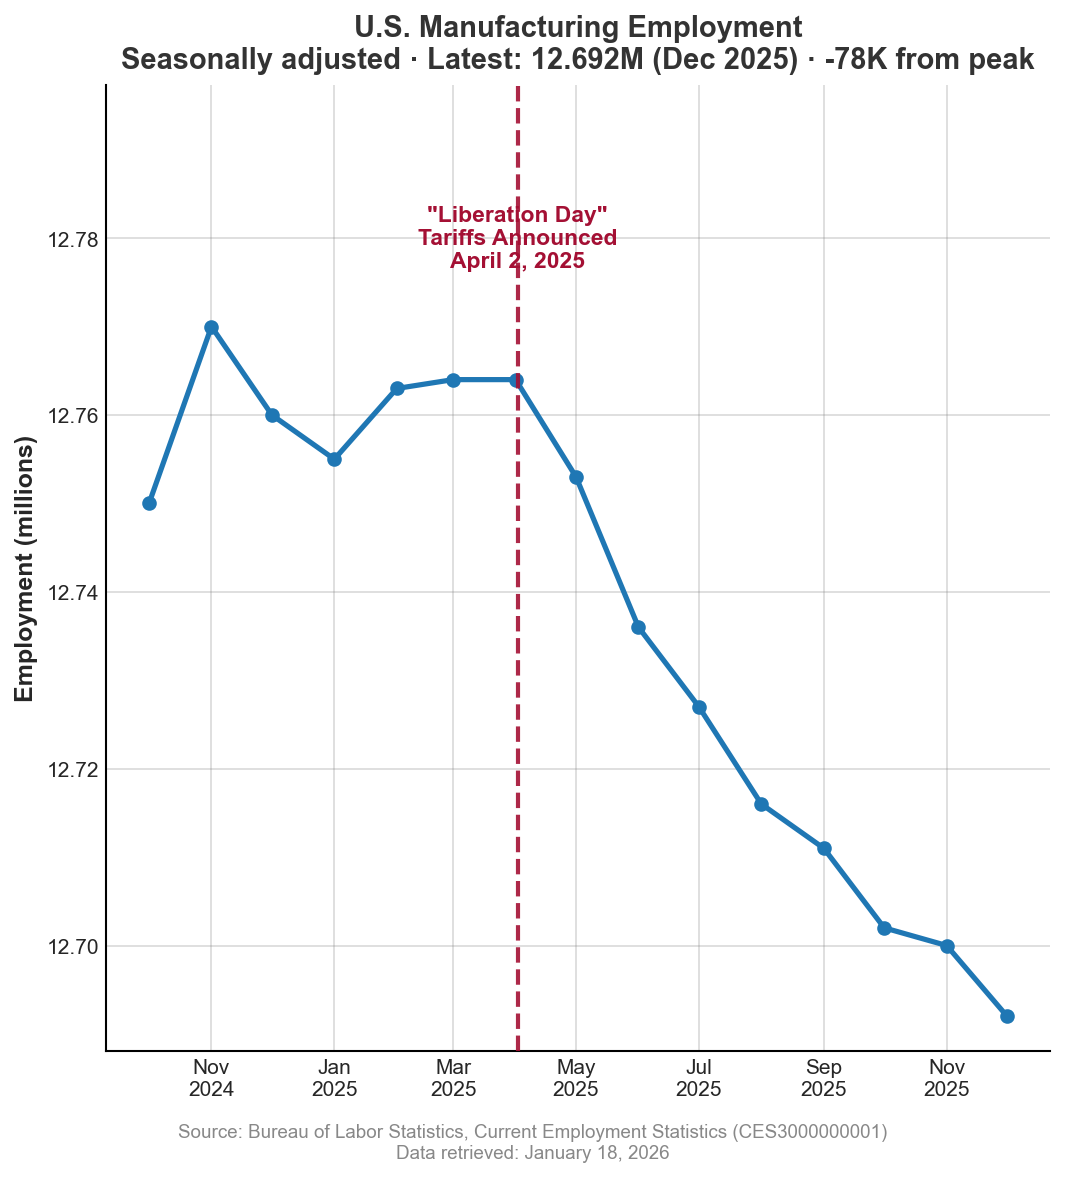

In [15]:
# Generate final visualization
output_path = FIGURE_DIR / 'manufacturing_employment.png'
fig, ax = create_final_visualization(df, output_path)
plt.show()

## 7. Methodology Notes

### Data Source
- **Series**: CES3000000001 - All Employees, Manufacturing (Seasonally Adjusted, Thousands)
- **Source**: Bureau of Labor Statistics, Current Employment Statistics survey
- **Frequency**: Monthly
- **API**: BLS Public Data API v2

### Key Decisions
1. **Seasonally adjusted data**: Used SA series to avoid confounding seasonal patterns with policy effects
2. **Year-over-year change**: Selected as primary metric because it:
   - Eliminates residual seasonality
   - Provides intuitive interpretation ("X% more/fewer jobs than last year")
   - Is robust to short-term noise
3. **Time range**: 2018-present for final viz to focus on recent trends while including COVID for context

### Limitations
- Employment data is released with ~1 month lag
- CES data undergoes revisions; early releases may be revised
- Manufacturing employment reflects many factors beyond tariff policy
- Correlation does not imply causation

### Visualization Approaches Tested
1. Raw levels - Shows absolute scale but trend changes hard to see
2. Month-over-month % - Too noisy for clear narrative
3. Year-over-year % - **Selected** - Clear trend visualization
4. Indexed to baseline - Good for recent focus, loses historical context
5. Deviation from trend - Requires trend assumptions, potentially misleading